In [3]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [9]:
data_dir = os.getenv('HOME')+'/aiffel/mini_bert/data'
model_dir = os.getenv('HOME')+'/aiffel/mini_bert'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_8000.model")

True

In [10]:
# 특수 token 7개를 제외한 나머지 token들 출력
vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))
print(vocab_list)

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다', '었다', '▁지', '▁수', '▁19', '▁가', '▁시', '▁20', '▁기', '▁전', '▁아', '▁하', '▁있다', '▁다', '▁제', '했다', '하였', '▁일', '▁한', '▁중', '▁정', '▁주', '하는', '▁것', '▁자', '▁공', '▁인', '되었다', '▁경', '▁위', '▁유', '▁보', '하고', '▁3', '▁등', '▁부', '하였다', '▁조', '하여', '▁미', '▁동', '▁선', '▁나', '으며', '▁모', '▁연', '▁영', '▁의', '▁오', '▁마', '에는', '▁발', '▁소', '한다', '▁고', '▁개', '▁201', '▁구', '▁세', '▁도', '▁상', '▁비', '▁스', '▁국', '▁서', '▁후', '▁여', '▁200', '▁때', '▁4', '▁성', '▁해', '▁관', '▁있는', '▁신', '▁프', '▁대한', '부터', '▁5', '▁방', '▁또', '지만', '▁(', '▁역', '되어', '▁않', '▁만', '▁"', '▁장', '▁바', '까지', '▁무', '▁남', '▁통', '▁현', '▁교', '▁같', '에게', '▁내', '학교', '▁문', '▁출', '▁거', '▁포', '▁결', '된다', '▁《', '적인', '이라', '▁6', '▁우', '적으로', '▁불', '▁원', '▁최', '▁10', '▁진', '▁생', '▁작', '▁어', '▁당', '국의', '▁노', '▁강', '▁알', '▁반', '▁7', '▁8', '▁계', '▁따', '▁파', '▁분', '▁없', '▁받', '▁말', '면서', '들이', 'or', '되었', '▁사용', "▁'", '▁두', '▁실', '에서는', '▁리', '들은', '▁명', '▁함', '▁단', '▁이후', '00', '하기', '▁예', '년에', '),',

In [11]:
vocab.piece_to_id("[SEP]")

4

# 데이터 전처리
1. Mask 생성
2. NSP Pair 생성
3. 데이터셋 완성
## 1. Mask 생성

In [12]:
# 전체 토큰의 15% mask 처리
mask_cnt = int((len(vocab_list) - 3) * 0.15)
mask_cnt

1199

In [13]:
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    tokens_copy = copy.deepcopy(tokens)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 현재 mask된 개수가 15%를 넘으면 중지
              break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
              continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens_copy[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens_copy[index]})
            tokens_copy[index] = masked_token
    
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]
            

    return tokens_copy, mask_idx, mask_label

## 2. NSP Pair 생성

In [14]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [15]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for [CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
            
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            #######################################

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
            
            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)
            #######################################
            print()

            current_chunk = []
            current_length = 0
    return instances

## 3. 데이터셋 완성

In [16]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [17]:
# 라인수
pretrain_json_path = os.getenv('HOME')+'/aiffel/bert_pretrain/data/bert_pre_train.json'
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

801001

In [18]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [19]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)
# pre_train_inputs
# >> (enc_tokens, segments)
# pre_train_labels
# >> (labels_nsp, labels_mlm)

  0%|          | 0/128000 [00:00<?, ?it/s]

/tmp/ipykernel_78/2049745891.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_78/2049745891.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

data load early stop 128000 128000


In [20]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,   10, 1605, 3599, 1755, 3630,   41, 3644,  830, 3624, 1135,
           52, 3599,   13,   81,   87, 1501, 2247,   25, 3779, 3873, 3667,
         3631, 3813, 3873, 4196, 3636, 3779, 3601,  249, 3725, 1232,   33,
           52, 3599,    6,    6,    6, 6322, 2780,   14, 1509,  168, 3877,
          414,  165, 1697, 4290, 3873, 3703, 3683,  593,   21, 5007,  399,
         1927, 3607,    6,    6,    6,    6,    6,    6,  103, 4313, 4290,
          613, 3638, 3718,   98, 3878, 3656,  256, 2543,  309,  337, 3735,
          181, 3616, 3603,  489,  376, 3599,    4,    6,    6,  207, 3714,
            6, 1042,  103, 3610, 3686, 3718,    6,    6,   37, 3418,  416,
          810, 3666, 3625,  131, 3662,    7, 3629,  203,  241, 3602, 1114,
         3724,  788,  243,    6,    6,    6,  663, 1647, 3682, 3682, 3625,
          203, 3008, 3625, 3616,   16, 3599,    4], dtype=int32),
 memmap([   5, 3676,  848, 3784, 1931,   58, 3676,  416, 2316, 3619, 3625,
         3617, 3744, 4335,   12, 3

# BERT 모델 구현

In [21]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask
print("슝=3")

슝=3


In [22]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

print("슝=3")

슝=3


In [23]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer
print("슝=3")

슝=3


In [24]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
print("슝=3")

슝=3


In [25]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs
print("슝=3")

슝=3


In [26]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed
print("슝=3")

슝=3


In [27]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out
print("슝=3")

슝=3


In [28]:
# Q. 주석과 코드를 참조하여 아래 클래스를 완성해주세요.
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out
print("슝=3")

슝=3


In [29]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val
print("슝=3")

슝=3


In [30]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out
print("슝=3")

슝=3


In [31]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed
print("슝=3")

슝=3


In [32]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs
print("슝=3")

슝=3


In [33]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model
print("슝=3")

슝=3


In [34]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

# Pretrain 진행

In [35]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴
print("슝=3")

슝=3


In [36]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy
print("슝=3")

슝=3


In [37]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr
print("슝=3")

슝=3


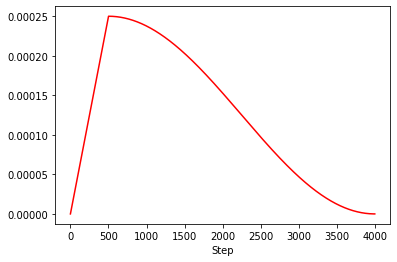

In [38]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [39]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 4485632     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                   

In [33]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


In [34]:
# callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/mini_bert.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="mlm_lm_acc", patience=3, verbose=1, restore_best_weights=True)
# train
history = pre_train_model.fit(x=pre_train_inputs, y=pre_train_labels, batch_size=batch_size, epochs=epochs, callbacks=[save_weights, early_stopping])

pre_train_model.save('mini_bert.keras')

Epoch 1/10
2000/2000 [==============================] - 311s 134ms/step - loss: 19.5987 - nsp_loss: 0.6503 - mlm_loss: 18.9484 - nsp_acc: 0.5899 - mlm_lm_acc: 0.1099

Epoch 00001: mlm_lm_acc improved from -inf to 0.10990, saving model to /aiffel/aiffel/mini_bert/mini_bert.hdf5
Epoch 2/10
2000/2000 [==============================] - 282s 141ms/step - loss: 17.5316 - nsp_loss: 0.6226 - mlm_loss: 16.9090 - nsp_acc: 0.6175 - mlm_lm_acc: 0.1294

Epoch 00002: mlm_lm_acc improved from 0.10990 to 0.12936, saving model to /aiffel/aiffel/mini_bert/mini_bert.hdf5
Epoch 3/10
2000/2000 [==============================] - 280s 140ms/step - loss: 16.4447 - nsp_loss: 0.6152 - mlm_loss: 15.8295 - nsp_acc: 0.6219 - mlm_lm_acc: 0.1433

Epoch 00003: mlm_lm_acc improved from 0.12936 to 0.14329, saving model to /aiffel/aiffel/mini_bert/mini_bert.hdf5
Epoch 4/10
2000/2000 [==============================] - 282s 141ms/step - loss: 14.4375 - nsp_loss: 0.6136 - mlm_loss: 13.8239 - nsp_acc: 0.6271 - mlm_lm_acc: 0

NotImplementedError: Layer BERT has arguments in `__init__` and therefore must override `get_config`.

In [ ]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# Inference

위에서 모델 학습을 돌려놓고 잤는데 에러가 나는 바람에 일단 저장된 가중치를 가지고 모델을 다시 만들었다.

In [41]:
pre_train_model.load_weights("mini_bert.hdf5")

In [42]:
vocab.piece_to_id('[CLS]')

5

In [43]:
vocab.encode('[CLS]')

[3596, 5]

In [44]:
vocab.encode('[CLS]', out_type=str)

['▁', '[CLS]']

In [45]:
vocab.piece_to_id('[PAD]')

0

In [46]:
vocab.pad_id()

0

In [47]:
vocab.encode_as_ids('[PAD]')

[1198, 3878, 3790, 3882, 4111]

In [48]:
vocab.encode('[PAD]', out_type=str)

['▁[', 'P', 'A', 'D', ']']

SentencePieceProcessor 인스턴스의 메서드 중 `piece_to_id()`와 달리 `encode()`는 입력된 텍스트를 하나의 piece가 아니라 쪼갤 수 있는 텍스트로 인식하고 [PAD] 토큰도 쪼개서 인코딩해버린다.  
이 때문에 밑에서 사용할 CLS, SEP, MASK, PAD 토큰 ID는 `piece_to_id()`메서드로 가져오기로 했다.

In [49]:
CLS_ID = vocab.piece_to_id("[CLS]")
SEP_ID = vocab.piece_to_id("[SEP]")
MASK_ID = vocab.piece_to_id("[MASK]")
PAD_ID = vocab.pad_id()

In [56]:
# --- Task 1: Next Sentence Prediction (NSP) ---
def predict_nsp(sentence1, sentence2, model=pre_train_model, tokenizer=vocab, config=config):
    """
    Predicts if sentence2 is the next sentence after sentence1.

    Args:
        sentence1 (str): The first sentence.
        sentence2 (str): The second sentence.
        model (tf.keras.Model): The trained BERT model.
        tokenizer (sentencepiece.SentencePieceProcessor): The SentencePiece tokenizer.
        config_obj (Config): The configuration object with n_seq.

    Returns:
        str: A string indicating whether the sentences are consecutive.
    """

    tokens_a = tokenizer.encode_as_ids(sentence1)
    tokens_b = tokenizer.encode_as_ids(sentence2)

    input_ids_list = [CLS_ID] + tokens_a + [SEP_ID] + tokens_b + [SEP_ID]
    segment_ids_list = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

    # 시퀀스 패딩
    input_ids_padded = tf.keras.preprocessing.sequence.pad_sequences(
        [input_ids_list],
        maxlen=config.n_seq,
        padding='post',
        truncating='post',
        value=PAD_ID,
        dtype='int32'
    )
    segment_ids_padded = tf.keras.preprocessing.sequence.pad_sequences(
        [segment_ids_list],
        maxlen=config.n_seq,
        padding='post',
        truncating='post',
        value=PAD_ID,
        dtype='int32'
    )
    
    nsp_pred_raw, _ = model.predict(
        [input_ids_padded, segment_ids_padded],
        verbose=1
    )
    
    predicted_label = np.argmax(nsp_pred_raw[0])
    
    if predicted_label == 0: # Assuming 0 means 'IsNext'
        return f"'{sentence2}' IS LIKELY the next sentence after '{sentence1}' (Prob IsNext: {nsp_pred_raw[0][0]:.4f})"
    else: # Assuming 1 means 'NotNext'
        return f"'{sentence2}' IS LIKELY NOT the next sentence after '{sentence1}' (Prob NotNext: {nsp_pred_raw[0][1]:.4f})"


In [62]:
# --- Task 2: Masked Language Model (MLM) ---
def predict_mlm(masked_sentence, model=pre_train_model, tokenizer=vocab, config=config, top_k=3):
    """
    Predicts the masked tokens in a sentence using tf.keras.preprocessing.sequence.pad_sequences.

    Args:
        masked_sentence (str): The sentence containing '[MASK]' tokens.
        model (tf.keras.Model): The trained BERT model.
        tokenizer (sentencepiece.SentencePieceProcessor): The SentencePiece tokenizer.
        config_obj (Config): The configuration object with n_seq.
        top_k (int): Number of top predictions to show for each mask.

    Returns:
        list: A list of strings, where each string describes the predictions for a masked token,
              plus the reconstructed sentence.
    """
    # 인코딩 하기 전에 좀 더 robust하게 마스킹하기 위해 masked_sentence에 있는 [MASK]를 실제 vocab의 [MASK] 토큰으로 교체 (차이 없을 수 있지만)
    mask_token_piece = tokenizer.id_to_piece(MASK_ID)
    processed_sentence = masked_sentence.replace("[MASK]", mask_token_piece)
    # 인코딩
    tokens = tokenizer.encode_as_ids(processed_sentence)

    input_ids_list = [CLS_ID] + tokens + [SEP_ID]
    mask_indices_in_sequence = [i for i, token_id in enumerate(input_ids_list) if token_id == MASK_ID]
    segment_ids_list = [0] * len(input_ids_list)

    # Pad sequences using tf.keras.preprocessing.sequence.pad_sequences
    input_ids_padded = tf.keras.preprocessing.sequence.pad_sequences(
        [input_ids_list],
        maxlen=config.n_seq,
        padding='post',
        truncating='post',
        value=PAD_ID,
        dtype='int32'
    )
    segment_ids_padded = tf.keras.preprocessing.sequence.pad_sequences(
        [segment_ids_list],
        maxlen=config.n_seq,
        padding='post',
        truncating='post',
        value=0,
        dtype='int32'
    )
    

    _, mlm_pred_raw = model.predict(
        [input_ids_padded, segment_ids_padded],
        verbose=1
    )
    
    predictions_for_masks = []
    # Get original tokens (pieces) for better context in output, including CLS and SEP
    original_tokens_pieces_with_specials = [tokenizer.id_to_piece(id) for id in input_ids_list]


    predicted_ids_for_reconstruction = list(input_ids_padded[0]) # Get the 1D array of padded input_ids

    for i, mask_idx_in_padded_seq in enumerate(mask_indices_in_sequence):
        # Ensure mask_idx_in_padded_seq is valid for the padded sequence length
        if mask_idx_in_padded_seq >= config.n_seq:
            predictions_for_masks.append(f"Mask {i+1} (at original token list index {mask_idx_in_padded_seq-1}) is outside max sequence length after padding.")
            continue
            
        token_probs = mlm_pred_raw[0, mask_idx_in_padded_seq, :]
        top_k_indices = np.argsort(token_probs)[-top_k:][::-1]
        top_k_tokens = [tokenizer.id_to_piece(int(idx)) for idx in top_k_indices]
        top_k_probs = [token_probs[idx] for idx in top_k_indices]

        # The mask_idx_in_padded_seq refers to the index in input_ids_list (which includes [CLS])
        # The "original token" here means the token at that position in the input_ids_list (which is [MASK])
        result_str = (f"Predictions for [MASK] at position {mask_idx_in_padded_seq} in the input sequence "
                      f" (original token: '{original_tokens_pieces_with_specials[mask_idx_in_padded_seq]}'):")

        for rank, (token, prob) in enumerate(zip(top_k_tokens, top_k_probs)):
            result_str += f"\n  {rank+1}. '{token}' (ID: {tokenizer.piece_to_id(token)}, Prob: {prob:.4f})"
        predictions_for_masks.append(result_str)
        
        if top_k_indices.size > 0:
             predicted_ids_for_reconstruction[mask_idx_in_padded_seq] = top_k_indices[0]

    # Decode the full sentence with best predictions
    # Remove CLS, SEP, and PAD tokens for cleaner output
    # Valid sequence length before padding was len(input_ids_list)
    # We need to slice predicted_ids_for_reconstruction based on original length before padding,
    # but also handle truncation if original len > max_seq.
    # The relevant part is from index 1 (after CLS) up to the SEP before padding.
    
    # Find the first PAD_ID after the initial sequence or end of sequence
    actual_len_in_padded = config.n_seq
    try:
        first_pad_index = list(predicted_ids_for_reconstruction).index(PAD_ID)
        if first_pad_index > 0: # Make sure PAD is not the first token (e.g. empty input)
             actual_len_in_padded = first_pad_index
    except ValueError: # No PAD_ID found, sequence uses full maxlen
        pass
    
    # Exclude [CLS] at the beginning, and [SEP] and padding at the end.
    # The tokens to decode are from index 1 up to where the meaningful sequence ends.
    # If original input was shorter than max_len: input_ids_list included CLS and SEP.
    # e.g. [CLS] t1 t2 [SEP] -> len=4. Padded to 256.
    # We want to decode t1 t2. These are at predicted_ids_for_reconstruction[1] and [2].
    # The SEP was at input_ids_list.index(SEP_ID) if only one SEP, or len(input_ids_list)-1
    
    end_of_sequence_idx = len(input_ids_list) -1 # Index of the last SEP before padding
    if end_of_sequence_idx > actual_len_in_padded : # handles truncation
        end_of_sequence_idx = actual_len_in_padded

    if end_of_sequence_idx > 1: # Ensure there's something between CLS and SEP
        ids_to_decode = predicted_ids_for_reconstruction[1:end_of_sequence_idx]
        reconstructed_sentence = tokenizer.decode_ids([int(id_val) for id_val in ids_to_decode]) # Ensure ids are int
        predictions_for_masks.append(f"\nReconstructed sentence (best guess): {reconstructed_sentence}")
    else:
        predictions_for_masks.append("\nReconstructed sentence (best guess): [Too short to reconstruct meaningfully]")

    return predictions_for_masks



In [57]:
# --- Test NSP ---
sentence_a = "오늘 날씨가 정말 좋네요."
sentence_b = "그래서 공원으로 산책을 갈까 해요."
sentence_c = "어제 축구 경기는 재미있었나요?"

print("--- NSP Predictions ---")
# Expected: Consecutive
nsp_result1 = predict_nsp(sentence_a, sentence_b)
print(f"NSP for ('{sentence_a}', '{sentence_b}'):\n{nsp_result1}\n")

# Expected: Not consecutive
nsp_result2 = predict_nsp(sentence_a, sentence_c)
print(f"NSP for ('{sentence_a}', '{sentence_c}'):\n{nsp_result2}\n")


--- NSP Predictions ---
1/1 [==============================] - 35s 35s/step
NSP for ('오늘 날씨가 정말 좋네요.', '그래서 공원으로 산책을 갈까 해요.'):
'그래서 공원으로 산책을 갈까 해요.' IS LIKELY NOT the next sentence after '오늘 날씨가 정말 좋네요.' (Prob NotNext: 0.5837)

1/1 [==============================] - 0s 25ms/step
NSP for ('오늘 날씨가 정말 좋네요.', '어제 축구 경기는 재미있었나요?'):
'어제 축구 경기는 재미있었나요?' IS LIKELY the next sentence after '오늘 날씨가 정말 좋네요.' (Prob IsNext: 0.5151)



In [63]:
# --- Test MLM ---
masked_sent_1 = "오늘 [MASK]가 정말 좋네요." # 명사 마스크 1개
masked_sent_2 = "[MASK]가 정말 맛있네요! 팔아도 되겠어요." # 명사 마스크 1개
masked_sent_3 = "[MASK]는 [MASK]를 좋아합니다." # 명사 마스크 여러 개
masked_sent_4 = "철수는 아침부터 신나게 [MASK]하는 중이다." # 동사 마스크
masked_sent_5 = "오늘 하늘이 참 [MASK]" # 형용사 마스크

print("\n--- MLM Predictions ---")
mlm_results_1 = predict_mlm(masked_sent_1)
print(f"MLM for '{masked_sent_1}':")
for res in mlm_results_1:
    print(res)
print("-" * 20)

mlm_results_2 = predict_mlm(masked_sent_2)
print(f"MLM for '{masked_sent_2}':")
for res in mlm_results_2:
    print(res)
print("-" * 20)

mlm_results_3 = predict_mlm(masked_sent_3)
print(f"MLM for '{masked_sent_3}':")
for res in mlm_results_3:
    print(res)
print("-" * 20)

mlm_results_4 = predict_mlm(masked_sent_4)
print(f"MLM for '{masked_sent_4}':")
for res in mlm_results_4:
    print(res)
print("-" * 20)

mlm_results_5 = predict_mlm(masked_sent_5)
print(f"MLM for '{masked_sent_5}':")
for res in mlm_results_5:
    print(res)
print("-" * 20)


--- MLM Predictions ---
1/1 [==============================] - 0s 26ms/step
MLM for '오늘 [MASK]가 정말 좋네요.':
Predictions for [MASK] at position 3 in the input sequence  (original token: '[MASK]'):
  1. '▁때문에' (ID: 326, Prob: 0.0266)
  2. '▁밖에' (ID: 3141, Prob: 0.0179)
  3. '▁날' (ID: 687, Prob: 0.0170)

Reconstructed sentence (best guess): 오늘  때문에가 정말 좋네요.
--------------------
1/1 [==============================] - 0s 25ms/step
MLM for '[MASK]가 정말 맛있네요! 팔아도 되겠어요.':
Predictions for [MASK] at position 2 in the input sequence  (original token: '[MASK]'):
  1. '▁밖에' (ID: 3141, Prob: 0.0391)
  2. '▁잎' (ID: 3244, Prob: 0.0146)
  3. '[UNK]' (ID: 1, Prob: 0.0124)

Reconstructed sentence (best guess): 밖에가 정말 맛있네요! 팔아도 되겠어요.
--------------------
1/1 [==============================] - 0s 24ms/step
MLM for '[MASK]는 [MASK]를 좋아합니다.':
Predictions for [MASK] at position 2 in the input sequence  (original token: '[MASK]'):
  1. '▁' (ID: 3596, Prob: 0.0178)
  2. '▁먹' (ID: 1144, Prob: 0.0151)
  3. '▁사람을' (I

# 회고

## 느낀 점
- NSP 태스크에서는 내가 예상한 것과 정반대의 결과를 얻었다. 하지만 probability가 0.5대인걸로 보아 그리 큰 확신의 예측은 아니다. 더 명백히 연속된/연속되지 않은 두 문장을 가지고 실험해야겠다.
    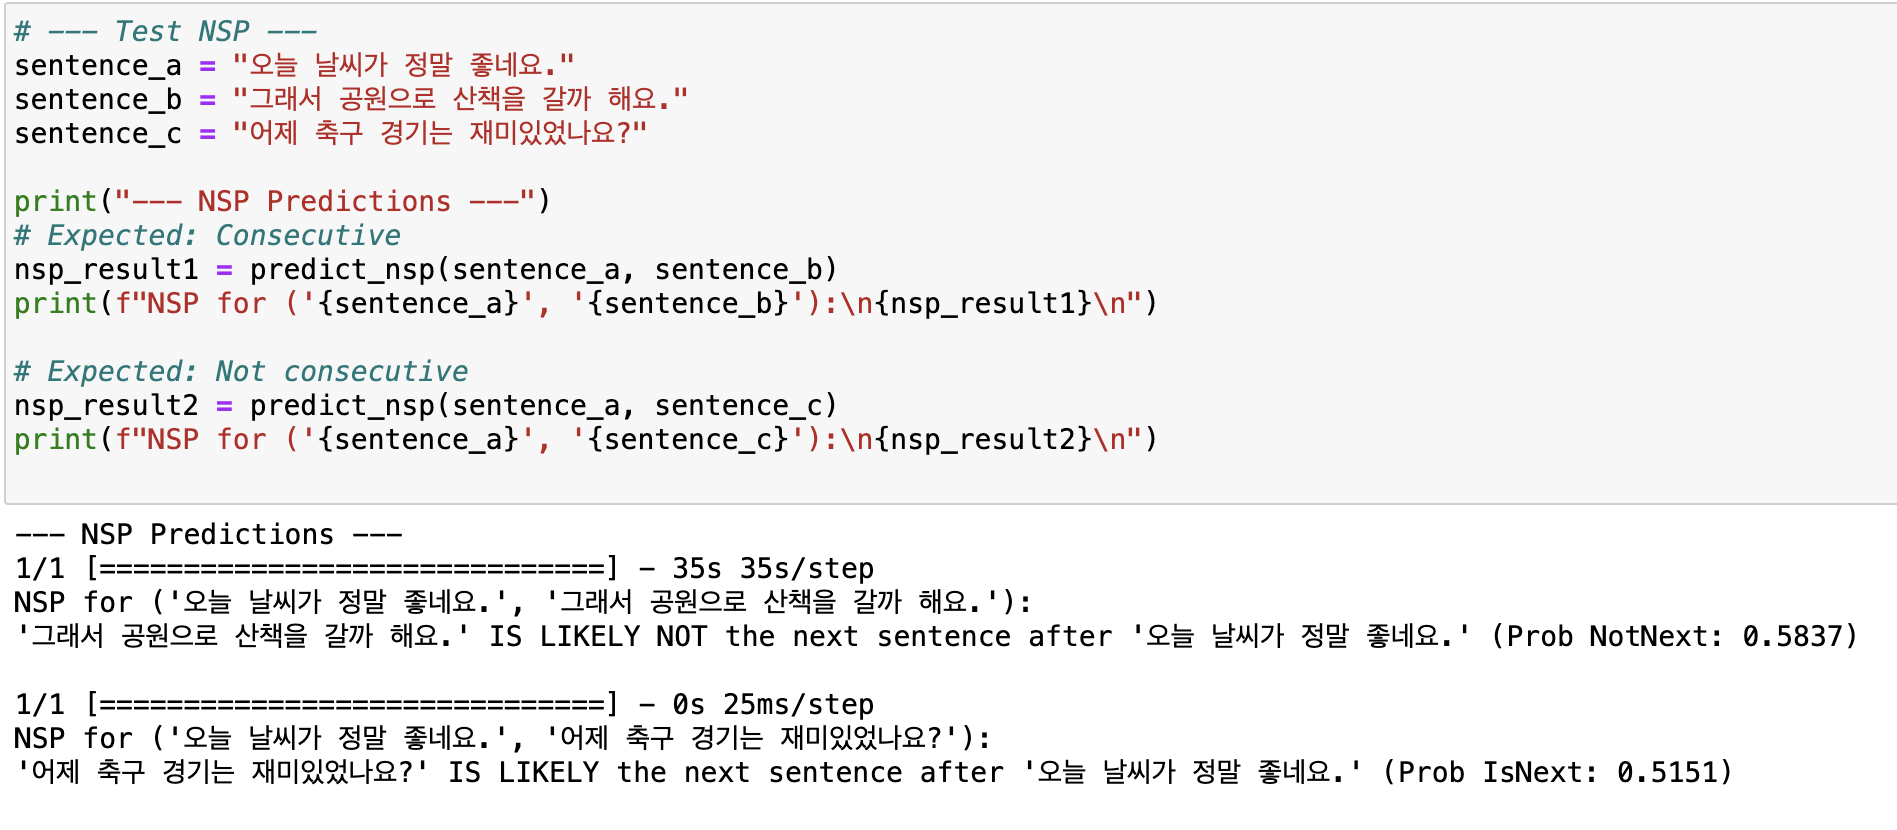

- MLM 태스크에서는 전혀 의도와 다른 엉뚱한 단어들을 MASK 예측값으로 출력했다.
    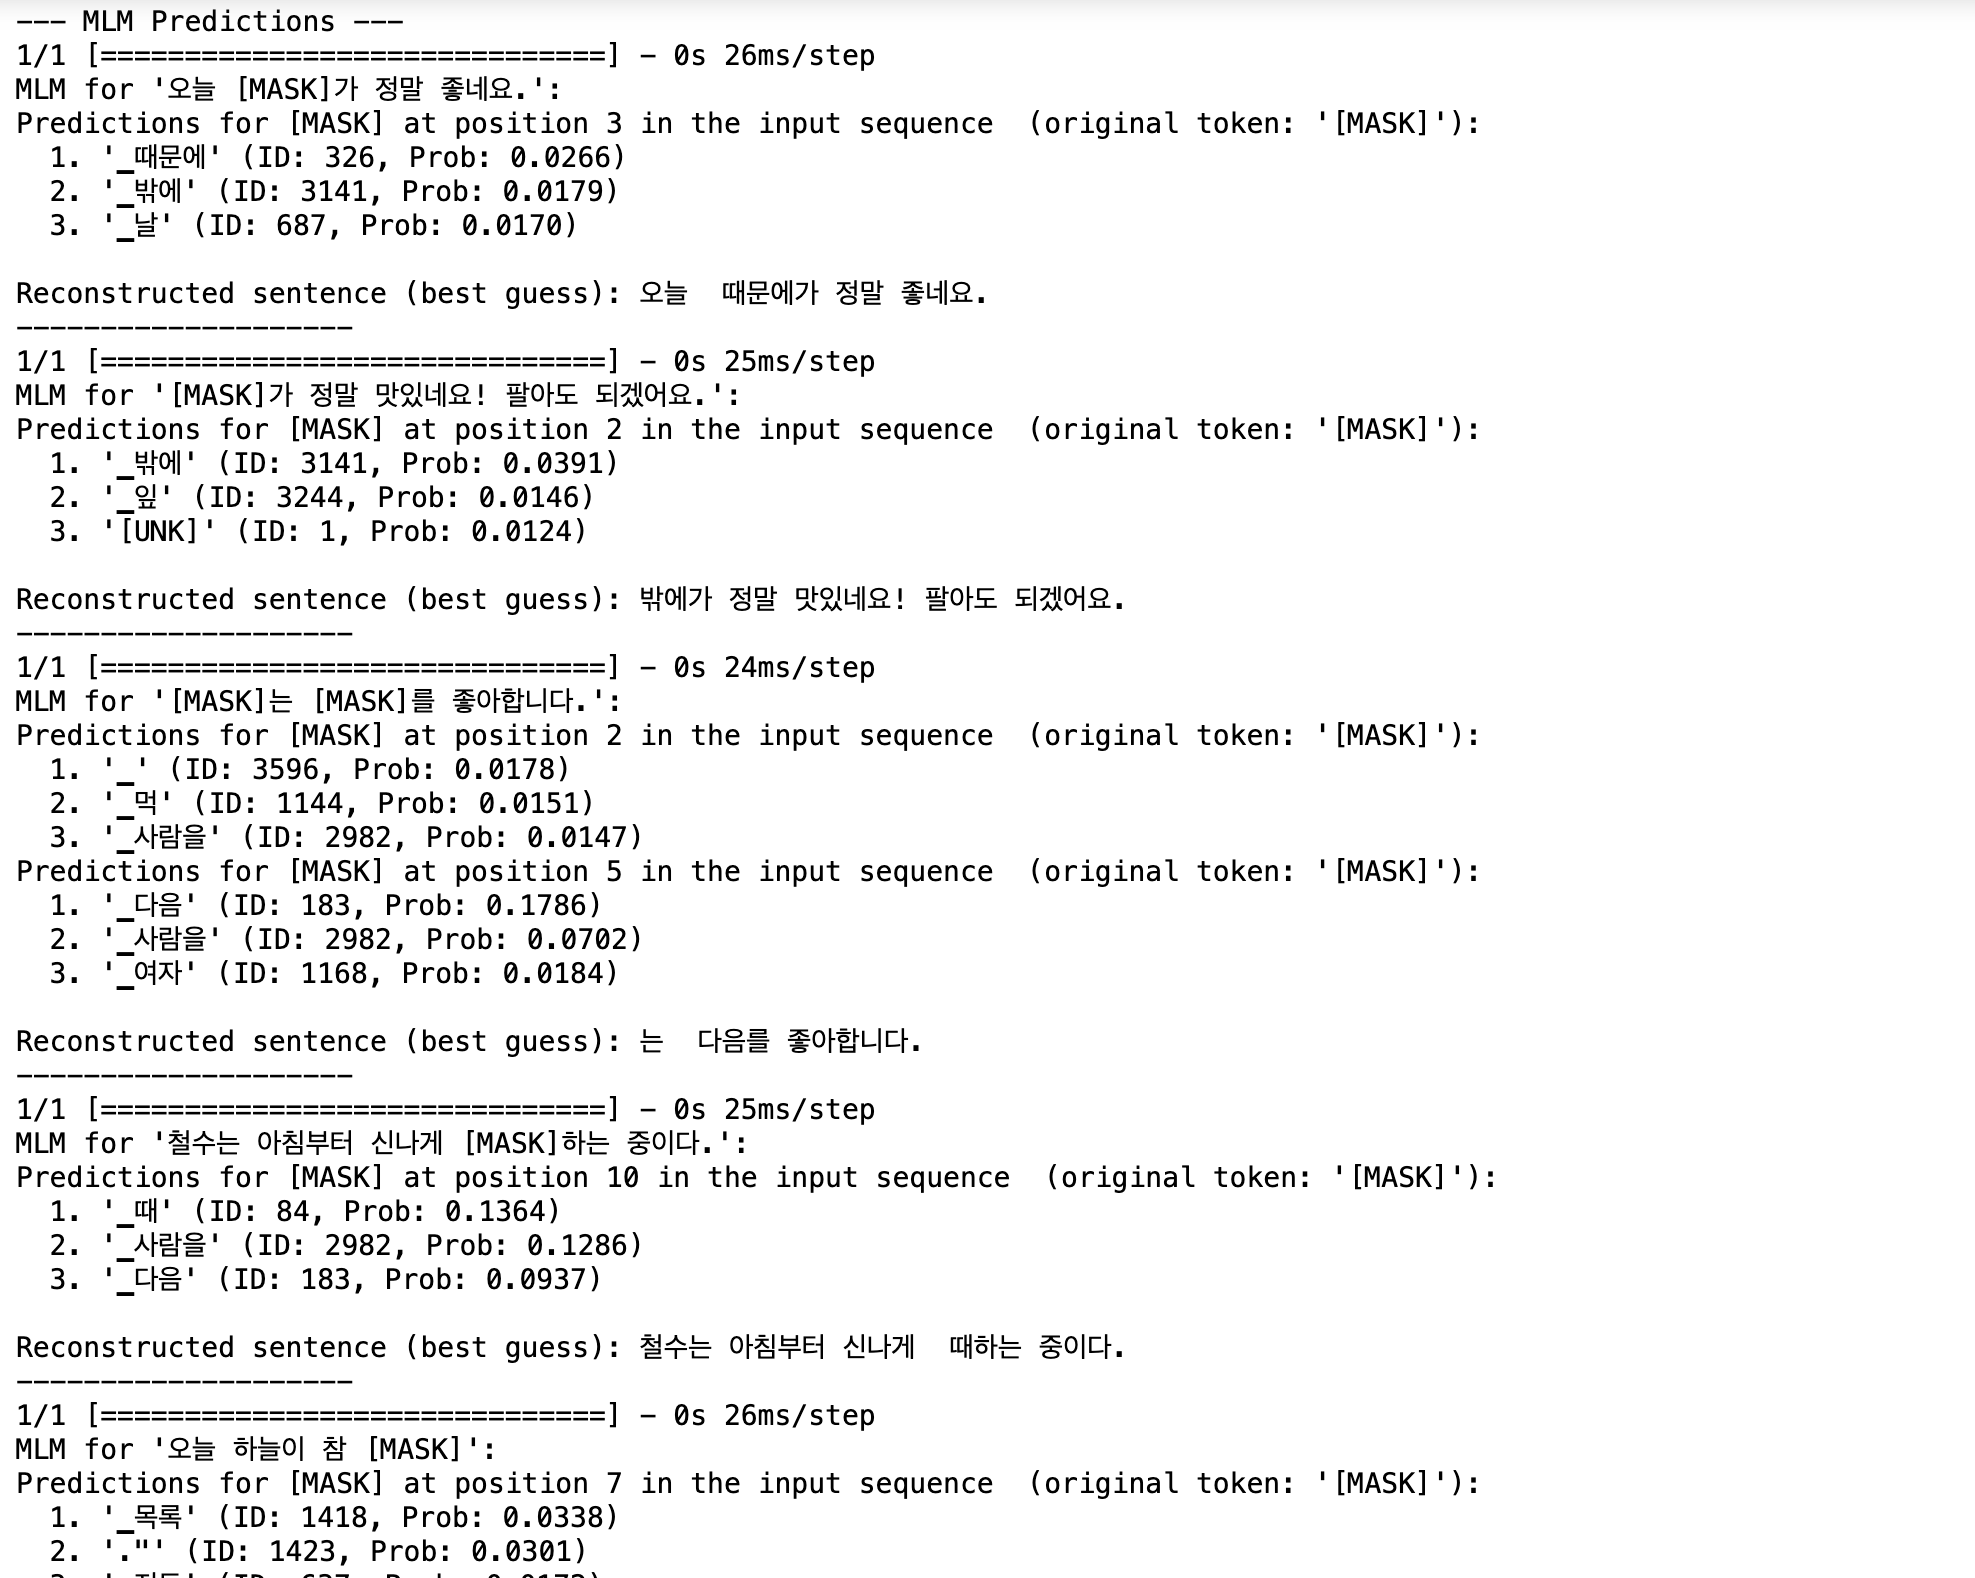

- 사실 학습 과정 중에 확인한 nsp_accuracy나 mlm_accuracy만 확인해도 어느정도 예견된 결과이다. nsp_accuracysms 0.6으로 0.5보다 살짝 높긴 하지만, mlm_accuracy는 0.3도 못 미치기 때문에 데이터 양이나 BERT 모델의 layer 수/hyperparameter 등 다른 요소들을 조정하면 더 높은 성능을 기대할 수 있을 듯하다.

## 알게 된 점
- 위에서 만든 spm의 인스턴스인 `vocab` tokenizer에서 `[PAD], [SEP], [CLS]` 토큰의 ID를 출력하려 했으나,
   spm 인스턴스에서 `.encode_as_ids()` method와 `piece_to_id` method의 출력이 다르다는 사실을 알게 됐다.
   예를 들어 `.encode([PAD])` 를 하면 '[PAD]'를 하나의 piece로 인식하는 게 아니라 character 단위로 쪼개서 encode해버림.
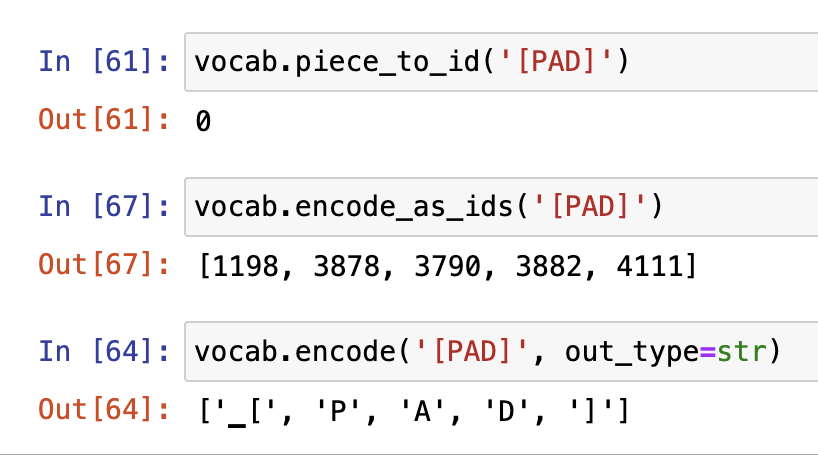

## 실수
1. 생각없이 노드의 코드를 갖다 쓰다가 `make_pretrain_data()`함수를 400만 라인에 적용해서 kernel이 끊겼다.